# Regression

In this notebook, we're going to set the foundations for how we can take a sample of inputs (data), build a regression mdoel to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.
We will go through all of these using both **sklearn** and **tensorflow** modules.

In [9]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 6)

import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.utils import plot_model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error

In [1]:
from sklearn.datasets import load

## Linear Regression

Let's begin with a simple linear regression problem.

### Data

Before we dive into modeling, we always begin with the data.

#### Data Exploration
Let's start by loading the dataset for linear regression.

In [2]:
# load data and check head
insurance_df = pd.read_csv("data/insurance.csv")
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Now let's have a quick look of the data.

In [3]:
# quick description of the data
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# summary of the numerical attributes
insurance_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


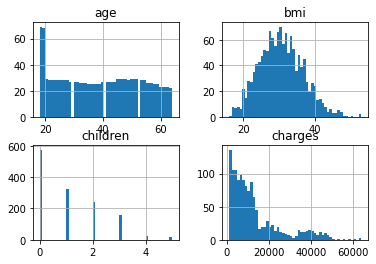

In [5]:
# histogram of numerical attributes
insurance_df.hist(bins=50)
plt.show()

#### Data Manipulation

Now let's split into features and targets and then into training and test datasets.

In [6]:
# features and target
X = insurance_df.drop("charges", axis=1)
y = insurance_df.charges

# split in train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 6), (268, 6), (1070,), (268,))

Finally, before moving on to modeling, let's **preprocess** the data in order to make them valid for deep learning models. In general, there are many data transformation steps that need to be executed in the right order before training. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

In [7]:
# preprocessing data pipeline
column_transformer = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # normalization
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"]) # one hot encoding
)

# fit the X_train data
column_transformer.fit(X_train)

# transform both X_train and X_test
X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 11), (268, 11), (1070,), (268,))

#### Models

Now, let's start training models. 

##### Linear Model
We will begin with a simple **Linear Regression** model as a baseline model.


In [21]:
# linear regression (baseline)
model_0 = LinearRegression()
model_0.fit(X_train, y_train)

LinearRegression()

In [15]:
# model predictions
y_pred = model_0.predict(X_test)

In [16]:
# model evaluation
mae_model_0 = mean_absolute_error(y_test, y_pred)
mae_model_0

4138.0869576455225

A better way to evaluate the model is instead of doing the splitting of the data to train and test dataset just once, to do it many times. The way it works, is that we split the dataset to K equal partitions called **folds**, and each time we use 1 of it for test, and the union of the rest for training. Usually we pick **K=10**. In the end all of them will have been used as training and test sets, and the average accuracy score will be the one of the model.

In [22]:
# model evaluation through Cross Validation
scores = cross_val_score(model_0, X_train, y_train, cv=10, scoring="neg_mean_absolute_error", n_jobs = -1)
-scores.mean()

4271.694415186916

##### Neural Network

Although there are many different architectures of a regresison neural network, the following list is a generic neural network architecture that we will see over and over: **Input layer shape**, **Hidden layer(s)**, **Neurons per hidden layer**, **Output layer shape**, **Hidden activation**, **Output activation**, **Loss function**, and **Optimizer**. Out of all of these components, one of the most important concepts when working with neural networks are the **input and output shapes**, being the shape of the data that goes into the model and the shape of the data we want to come out of the model respectively. These will differ depending on the problem. Making sure the input and outputs are in the correct shape is vital.

In TensorFlow, there are typically 5 **fundamental steps to creating and training a model**.

1. **Create The Model:** Piece together the layers of a neural network (using the Functional or Sequential API) or import a previously built model (transfer learning).
2. **Compile The Model:** Define all the important concepts of the network.
    1. **Loss:** How wrong your model's predictions are compared to the truth labels (you want to minimise this).
    2. **Optimizer:** How your model should update its internal patterns to better its predictions.
    3. **Metrics:** Human interpretable values for how well your model is doing.
3. **Fit The Model:** Let the model try to find patterns in the data by iterating over epochs (how many times the model will go through all of the training examples).
4. **Evaluate The Model:** Evaluate the performance of the model based on the metrics.
5. **Improve The Model:** Iterate over the 4 first steps by making small adjustments in order to improve the model. Most common ways to improve a deep model are: **Add layers**, **Improve the number of hidden units**, **Change the activation function**, **Change the optimization function**, **Change the learning rate**, **Fit on more data** and **Fit for longer**.

Now let's go over the 5 fundamental steps.

In [24]:
# 1. Create The Model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile The Model
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mae"])

# 3. Fit The Model
history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test,y_test))

Epoch 1/5
34/34 [==============================] - 0s 2ms/step - loss: 13344.8398 - mae: 13344.8398 - val_loss: 12966.6074 - val_mae: 12966.6074
Epoch 2/5
34/34 [==============================] - 0s 710us/step - loss: 13343.8760 - mae: 13343.8760 - val_loss: 12965.6396 - val_mae: 12965.6396
Epoch 3/5
34/34 [==============================] - 0s 653us/step - loss: 13342.9072 - mae: 13342.9072 - val_loss: 12964.6758 - val_mae: 12964.6758
Epoch 4/5
34/34 [==============================] - 0s 616us/step - loss: 13341.9414 - mae: 13341.9414 - val_loss: 12963.7119 - val_mae: 12963.7119
Epoch 5/5
34/34 [==============================] - 0s 619us/step - loss: 13340.9736 - mae: 13340.9736 - val_loss: 12962.7441 - val_mae: 12962.7441


The process of step **4. Evaluate The Model** is not really automated and it contains a multiple of steps depending on the problem. Here I will introduce some very basic steps one can perform.

In [25]:
# summary of the model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


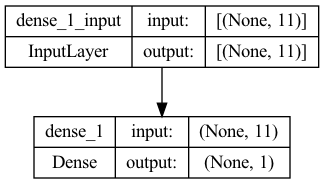

In [26]:
# architecture of the model
plot_model(model_1, show_shapes=True)

In [27]:
def plot(history):
    pd.DataFrame(history.history).plot(title="Metrics", xlabel='Epoch', ylabel='Metric')
    plt.show()

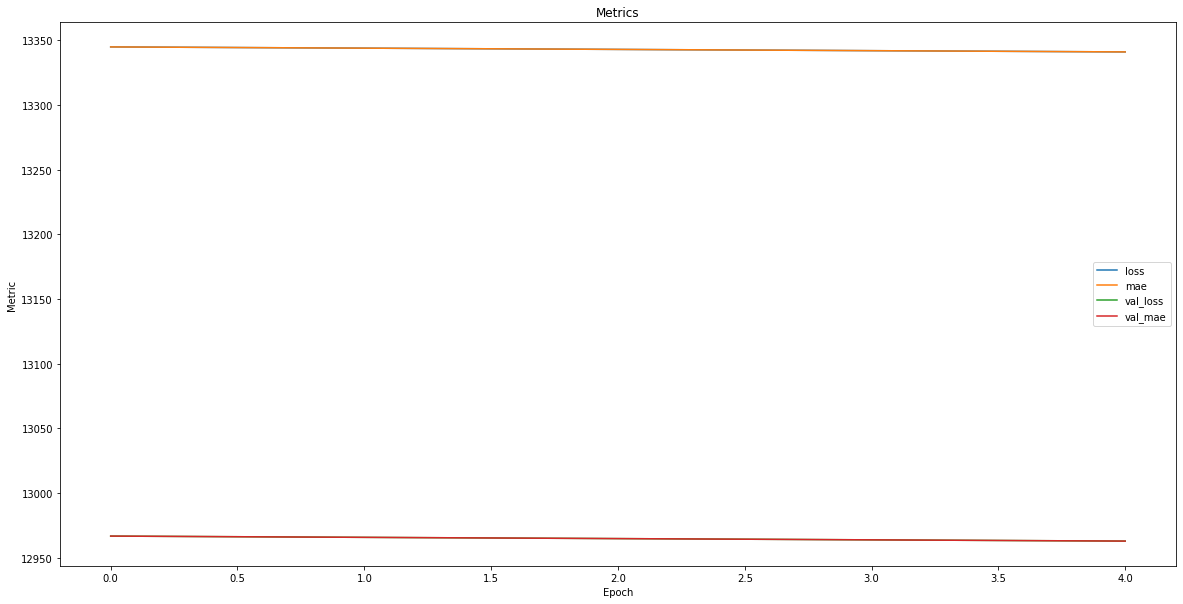

In [28]:
plot(history_1)

Moving on to fifth and final step **5. Improve The Model**, we will try to make improvements to the model by making small adjustments to the model. 

Let's start by training the model for longer, i.e increase the number of epochs.

In [29]:
# 1. Create The Model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile The Model
model_2.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# 3. Fit The Model
history_2 = model_2.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

# 4. Evaluate The Model
model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 344us/step - loss: 12872.2129 - mae: 12872.2129


[12872.212890625, 12872.212890625]

Moving on to **4. Evaluate The Model** let's take a look again to the various metrics.

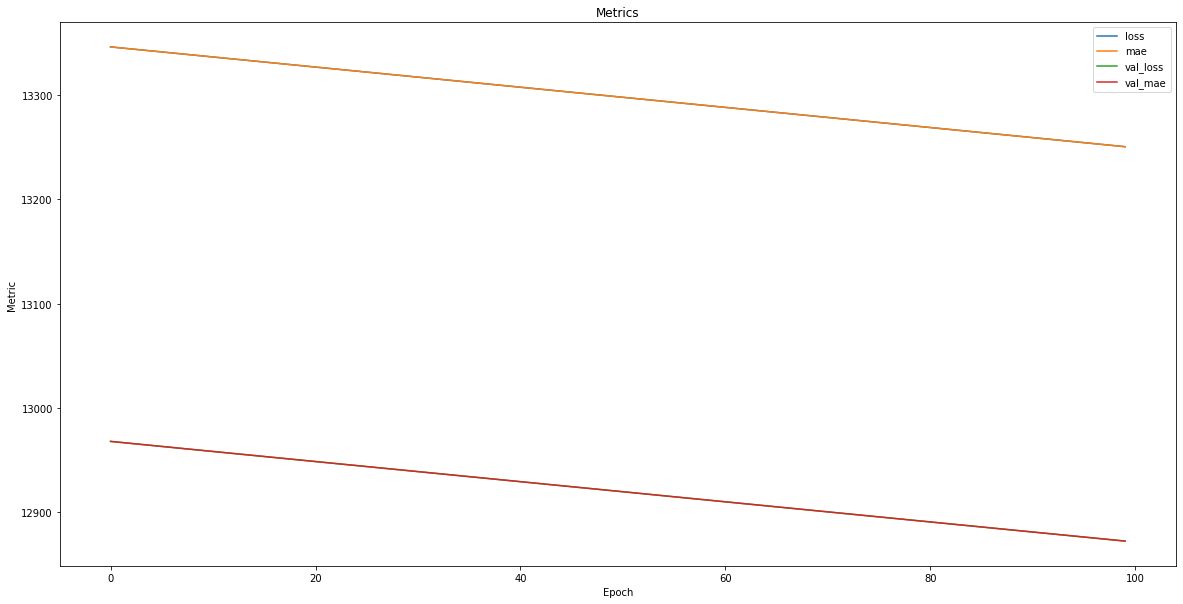

In [30]:
# plot model metrics
plot(history_2)

It looks like training for longer improved the model. Now let's again move on to **5. Improve The Model** step by running another experiment in which we will add an extra layer with one hidden unit increasing the epochs to 500. 

In [31]:
# 1. Create The Model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])

# 2. Compile The Model
model_3.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# 3. Fit The Model
history_3 = model_3.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

# 4. Evaluate The Model
model_3.evaluate(X_test, y_test)

9/9 [==============================] - 0s 346us/step - loss: 3166.3899 - mae: 3166.3899


[3166.389892578125, 3166.389892578125]

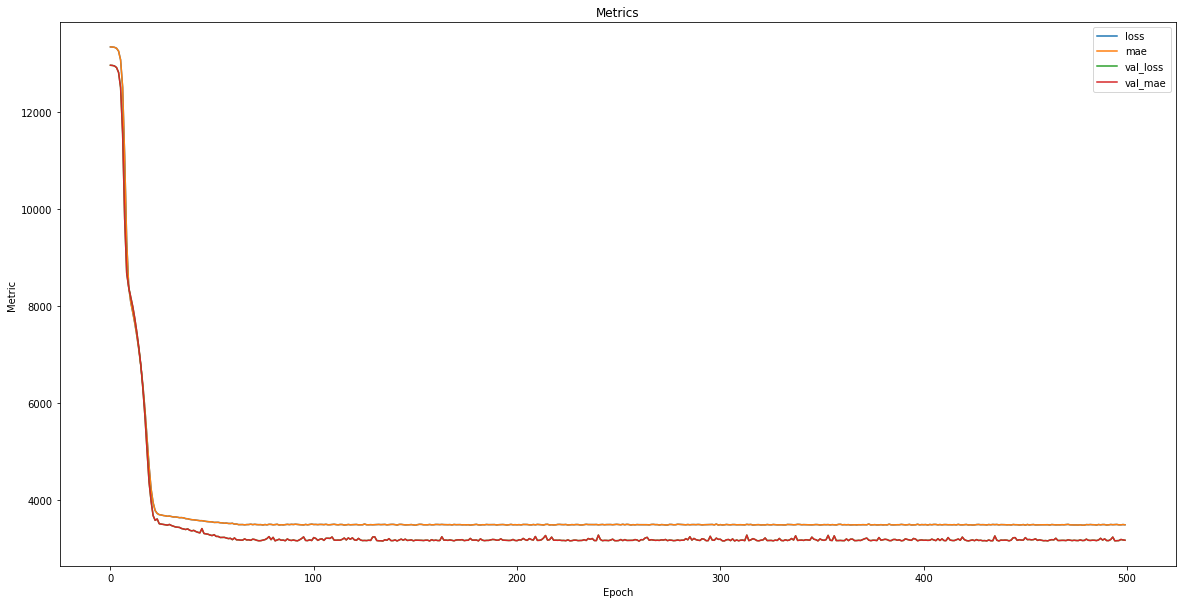

In [32]:
# plot model metrics
plot(history_3)

It looks like that model_3 has improved significantly over model_2, while the extra epochs in training did not hepl a lot since already after the first 100 epochs the model has a consistent loss.

After we have found a good model (in our case we can go with model_3), we can make predictions and save the model for future use.

In [ ]:
# make predictions
y_pred = model_3.predict(X_test)

In [ ]:
# save the mode
model_3.save('model_3')

In [ ]:
# load a saved model
model_3 = tf.keras.models.load_model("model_3")

## Classification

### Binary Classification

#### Data

Let's start again by loading the data, split them up and preprocess them.

In [ ]:
breast_cancer_df = pd.read_csv("data/breast_cancer.csv")
breast_cancer_df.head()

In [ ]:
# check out labels
labels = breast_cancer_df.target.value_counts()
labels

In [ ]:
# most frequent dummy classifier
most_frequent_classifier_accuracy = labels[1]/labels.sum()
most_frequent_classifier_accuracy

In [ ]:
# features and target
X = breast_cancer_df.drop("target", axis=1)
y = breast_cancer_df.target

# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
#preprocessing data (for deep learning usually normalization)
column_transformer = make_column_transformer(
    (MinMaxScaler(), breast_cancer_df.drop("target", axis=1).columns)
)

# fit the X_train data
column_transformer.fit(X_train)

# transform both X_train and X_test
X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### Models

Now let's go over the 5 fundamental steps once again.

In [ ]:
# 1. Create The Model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compile The Model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

# 3. Fit The Model
history_4 = model_4.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

# 4. Evaluate The Model
model_4.evaluate(X_test, y_test)

In [ ]:
# summary of the model
model_4.summary()

In [ ]:
# architecture of the model
plot_model(model_4, show_shapes=True)

In [ ]:
plot(history_4)

Moving on to fifth and final step **5. Improve The Model**, we will try to make improvements to the model by making small adjustments to the model. 

In [ ]:
# 1. Create The Model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compile The Model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 3. Fit The Model
history_5 = model_5.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

# 4. Evaluate The Model
model_5.evaluate(X_test, y_test)

In [ ]:
plot(history_5)

In [ ]:
# 1. Create The Model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compile The Model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])

# 3. Fit The Model
history_6 = model_6.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_test, y_test))

# 4. Evaluate The Model
model_6.evaluate(X_test, y_test)

In [ ]:
plot(history_6)

Looks like model_5 is the winner.

In [ ]:
# confusion matrix for model_5
y_pred = model_5.predict(X_test, verbose=0)
classification_evaluation(y_test, y_pred)

### Multiclass Classification

#### Data

In [ ]:
# data has already been sorted into training and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# plot a single random example
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

random_integer = random.randint(0, X_train.shape[0])

plt.imshow(X_train[random_integer], cmap=plt.cm.binary)
plt.title(class_names[y_train[random_integer]])
plt.show()

In [ ]:
# data min and max
X_train.min(), X_train.max()

In [ ]:
# normalization
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

#### Models

In [ ]:
# create the model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784, the Flatten layer does this for us)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# compile the model
model_7.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_7 = model_7.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# evaluate the model
model_7.evaluate(X_test, y_test)

In [ ]:
plot(history_7)

Finding the best learning rate.

To find the ideal learning rate (i.e the learning rate where the loss decreases the most during training) we are going to use the learning rate callback.

Callbacks are functions or blocks of code which are executed during a specific instant while training a Deep Learning Model.




In [ ]:
# create the model
model_8 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to reshape 28x28 to 784, the Flatten layer does this for us)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") # output shape is 10, activation is softmax
])

# compile the model
model_8.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# create a leraning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# fit the model
history_8 = model_8.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[lr_callback])

# evaluate the model
model_8.evaluate(X_test, y_test)

In [ ]:
plot(history_8)

In [ ]:
history_8_df = pd.DataFrame(history_8.history)
plt.semilogx(history_8_df.lr, history_8_df.loss)
plt.show()

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 


def classification_evaluation(y_test, y_pred):
    
    y_test, y_pred = tf.round(y_test), tf.round(y_pred)

    # create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # normalize confusion matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    n_classes = cm.shape[0]

    # prettify confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))

    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
           xlabel="Predicted Label",
           ylabel="True Label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=15)
    
    plt.show()
    
    accuracy = round(accuracy_score(y_test, y_pred),3)
    print("Accuracy = ", accuracy)
    
    precision = round(precision_score(y_test, y_pred),3)
    print("Precision = ", precision)
    
    recall = round(recall_score(y_test, y_pred),3)
    print("Recall = ", recall)
    
    f_1_score = round(f1_score(y_test, y_pred),3)
    print("F1 Score = ", f_1_score)

